# Invoice Extraction Model Training

This notebook implements training for layout-aware invoice extraction models with minimum 20 training iterations.
## Training Architecture
- **Hybrid Approach**: Regex + Machine Learning NER
- **Layout-aware Features**: Position and bounding box information
- **Indonesian Tokenization**: Custom tokenizer for Indonesian text
- **Early Stopping**: Monitor F1-score validation with patience
- **Learning Rate Scheduling**: Adaptive learning rate

In [13]:
import sys
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Add parent directory to path
sys.path.append('..')
from extraction_service import InvoiceExtractor

print("✓ Model training notebook initialized")
print(f"✓ Working directory: {os.getcwd()}")


✓ Model training notebook initialized
✓ Working directory: /Users/santana_mena/Desktop/PROGRAMMING/TELKOM SIGMA/barunih/InvoiceExtractor/notebooks


## 1. Load Prepared Data


In [16]:
with open('../data/augmented_dataset.json', 'r', encoding='utf-8') as f:
    dataset = json.load(f)
with open('../data/metadata.json', 'r', encoding='utf-8') as f:
    metadata = json.load(f)
with open('../data/label_distribution.json', 'r', encoding='utf-8') as f:
    label_distribution = json.load(f)

print(f"✓ Loaded dataset with {len(dataset)} samples")
print(f"✓ Entity types: {len(metadata['entity_types'])}")
print(f"✓ Unique labels: {len(metadata['unique_labels'])}")


✓ Loaded dataset with 300 samples
✓ Entity types: 20
✓ Unique labels: 16


## 2. Indonesian Custom Tokenizer

In [17]:
# %%
import re
from typing import List, Dict, Tuple

class IndonesianTokenizer:
    """Custom tokenizer for Indonesian invoice documents"""
    def __init__(self):
        self.currency_pattern = r'(?:Rp\.?|IDR|Rupiah)\s*[\d,\.]+'
        self.date_pattern     = r'\d{1,2}[\-/]\d{1,2}[\-/]\d{2,4}'
        self.npwp_pattern     = r'\d{2}\.\d{3}\.\d{3}\.\d{1}-\d{3}\.\d{3}'
        self.company_pattern  = r'(?:PT|CV|UD)\s+[A-Z\s]+'
        self.stopwords = {
            'dan','atau','yang','untuk','dengan','dari','pada','ke','di','dalam',
            'adalah','akan','sudah','telah','dapat','harus','bisa','tidak','belum'
        }

    def tokenize(self, text: str) -> List[str]:
        special_tokens = []
        processed_text = text
        patterns = [
            (self.currency_pattern, 'CURRENCY_TOKEN'),
            (self.date_pattern,     'DATE_TOKEN'),
            (self.npwp_pattern,     'NPWP_TOKEN'),
            (self.company_pattern,  'COMPANY_TOKEN')
        ]
        for pattern, token_type in patterns:
            for match in re.finditer(pattern, processed_text):
                placeholder = f'<{token_type}_{len(special_tokens)}>'
                special_tokens.append((placeholder, match.group()))
                processed_text = processed_text.replace(match.group(), placeholder, 1)

        tokens = re.findall(r'\b\w+\b|[^\w\s]', processed_text)
        for placeholder, original in special_tokens:
            tokens = [original if t == placeholder else t for t in tokens]
        return tokens

    def preprocess_for_training(self,
        samples: List[Dict]
    ) -> Tuple[List[List[str]], List[List[str]]]:
        X, y = [], []
        for sample in samples:
            tokens = self.tokenize(sample['text'])
            labels = sample['labels'][:len(tokens)]
            while len(labels) < len(tokens):
                labels.append('O')
            X.append(tokens)
            y.append(labels)
        return X, y

tokenizer = IndonesianTokenizer()
sample_text = dataset[0]['text']
tokens = tokenizer.tokenize(sample_text)
print("✓ Sample tokenization:")
print("   Original:", sample_text[:100], "...")
print("   Tokens:", tokens[:10], "...")
print("   Token count:", len(tokens))


✓ Sample tokenization:
   Original: INVOICE NO: INV-1556-832 DATE: 10/01/2024 PT TELKOM INDONESIA NPWP: 01.85.-601.1--151.797 TOTAL: 643 ...
   Tokens: ['INVOICE', 'NO', ':', 'INV', '-', '1556', '-', '832', 'DATE', ':'] ...
   Token count: 35


## 3. Feature Engineering for Layout-Aware Training


In [21]:
class LayoutAwareFeatureExtractor:
    """Extract layout-aware features for invoice text"""
    def __init__(self):
        self.tfidf = TfidfVectorizer(max_features=1000, ngram_range=(1,2))
        self.label_encoder = LabelEncoder()

    def extract_features(self,
        tokens: List[str],
        position_idx: int = 0
    ) -> Dict[str,float]:
        if position_idx>=len(tokens): return {}
        token = tokens[position_idx]
        features = {
            'token_length':       len(token),
            'is_numeric':         float(token.isdigit()),
            'is_alpha':           float(token.isalpha()),
            'is_alphanumeric':    float(token.isalnum()),
            'is_upper':           float(token.isupper()),
            'is_lower':           float(token.islower()),
            'is_title':           float(token.istitle()),
            'relative_position':  position_idx/len(tokens),
            'is_beginning':       float(position_idx<3),
            'is_end':             float(position_idx>len(tokens)-3),
            'is_middle':          float(0.3<=position_idx/len(tokens)<=0.7),
            'contains_digit':     float(any(c.isdigit() for c in token)),
            'contains_punct':     float(any(c in '.,:-/\\' for c in token)),
            'is_currency_like':   float(re.match(r'.*[Rr]p.*|.*IDR.*|.*\d+[,\.]\d+.*', token) is not None),
            'is_date_like':       float(re.match(r'\d{1,2}[\-/]\d{1,2}[\-/]\d{2,4}', token) is not None),
            'is_npwp_like':       float(re.match(r'\d{2}\.\d{3}\.\d{3}\.\d{1}-\d{3}\.\d{3}', token) is not None),
        }
        prev = tokens[position_idx-1] if position_idx>0 else ''
        nxt  = tokens[position_idx+1] if position_idx<len(tokens)-1 else ''
        features.update({
            'prev_is_numeric': float(prev.isdigit()),
            'prev_is_punct':   float(prev in '.,:-'),
            'next_is_numeric': float(nxt.isdigit()),
            'next_is_punct':   float(nxt in '.,:-'),
            'is_indonesian_keyword': float(token.lower() in
                ['invoice','faktur','tagihan','pembayaran','total','jumlah','npwp','pajak'])
        })
        return features

    def prepare_training_data(self,
        X_tokens: List[List[str]],
        y_labels: List[List[str]]
    ) -> Tuple[np.ndarray,np.ndarray]:
        feats, labs = [], []
        for tokens, labels in zip(X_tokens, y_labels):
            for i, lbl in enumerate(labels):
                fdict = self.extract_features(tokens,i)
                feats.append(list(fdict.values()))
                labs.append(lbl)
        X = np.array(feats)
        y = self.label_encoder.fit_transform(labs)
        return X, y

feature_extractor = LayoutAwareFeatureExtractor()
X_tokens, y_labels = tokenizer.preprocess_for_training(dataset)
X_features, y_encoded = feature_extractor.prepare_training_data(X_tokens,y_labels)

print("✓ Feature extraction completed")
print(f"   - Feature matrix shape: {X_features.shape}")
print(f"   - Labels shape: {y_encoded.shape}")
print(f"   - Unique labels: {len(feature_extractor.label_encoder.classes_)}")


✓ Feature extraction completed
   - Feature matrix shape: (9387, 21)
   - Labels shape: (9387,)
   - Unique labels: 16


## 4. Training Loop with 20+ Iterations


In [22]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import time

class InvoiceModelTrainer:
    """Train invoice extraction models with multiple iterations"""
    def __init__(self, min_iterations: int = 20):
        self.min_iterations = min_iterations
        self.training_history = []
        self.best_model = None
        self.best_f1_score = 0.0
        self.models = {
            'Random Forest':      RandomForestClassifier(n_estimators=100, random_state=42),
            'Gradient Boosting':  GradientBoostingClassifier(n_estimators=100, random_state=42),
            'Logistic Regression':LogisticRegression(max_iter=1000, random_state=42),
            'SVM':                SVC(kernel='rbf', random_state=42)
        }

    def train_iteration(self, X_train, X_val, y_train, y_val, model_name:str, iteration:int):
        start = time.time()
        mdl = self.models[model_name]
        mdl.fit(X_train,y_train)
        y_tr = mdl.predict(X_train)
        y_vl = mdl.predict(X_val)
        tr_f1 = f1_score(y_train,y_tr,average='weighted')
        vl_f1 = f1_score(y_val  ,y_vl,average='weighted')
        elapsed = time.time()-start
        self.training_history.append({
            'iteration': iteration,
            'model': model_name,
            'train_f1': tr_f1,
            'val_f1':   vl_f1,
            'training_time': elapsed
        })
        if vl_f1>self.best_f1_score:
            self.best_f1_score = vl_f1
            self.best_model = (model_name, mdl)

    def _randomize_model_params(self, name:str):
        if name=='Random Forest':
            self.models[name]=RandomForestClassifier(
                n_estimators=np.random.choice([50,100,200]),
                max_depth   =np.random.choice([10,20,None]),
                random_state=np.random.randint(1,100)
            )
        elif name=='Gradient Boosting':
            self.models[name]=GradientBoostingClassifier(
                n_estimators  =np.random.choice([50,100,200]),
                learning_rate=np.random.choice([0.1,0.2,0.3]),
                random_state =np.random.randint(1,100)
            )
        elif name=='Logistic Regression':
            self.models[name]=LogisticRegression(
                C            =np.random.choice([0.1,1.0,10.0]),
                max_iter     =1000,
                random_state =np.random.randint(1,100)
            )

    def run_training_iterations(self, X, y, test_size:float=0.2):
        print(f"🚀 Starting training (≥{self.min_iterations} iters)")
        print(f"📊 Samples: {len(X)}, Features: {X.shape[1]}")
        X_tr,X_vl,y_tr,y_vl = train_test_split(
            X,y,test_size=test_size,random_state=42,stratify=y
        )
        it=0
        for rnd in range(5):
            for name in self.models:
                it+=1
                print(f"⚡ Iter {it}: {name} (Round {rnd+1})")
                if it>4:
                    self._randomize_model_params(name)
                self.train_iteration(X_tr,X_vl,y_tr,y_vl,name,it)
                last=self.training_history[-1]
                print(f"   Train F1: {last['train_f1']:.4f}, Val F1: {last['val_f1']:.4f}, Time: {last['training_time']:.2f}s")
                if it>=self.min_iterations and last['val_f1']>0.9:
                    print(f"🎯 Target achieved at iter {it}")
                    break
            if it>=self.min_iterations:
                break
        print(f"✅ Completed {it} iterations")
        print(f"🏆 Best model: {self.best_model[0]} (F1={self.best_f1_score:.4f})")
        return self.training_history

trainer = InvoiceModelTrainer(min_iterations=20)
training_history = trainer.run_training_iterations(X_features, y_encoded)


🚀 Starting training (≥20 iters)
📊 Samples: 9387, Features: 21
⚡ Iter 1: Random Forest (Round 1)
   Train F1: 0.9663, Val F1: 0.9596, Time: 0.25s
⚡ Iter 2: Gradient Boosting (Round 1)
   Train F1: 0.9655, Val F1: 0.9594, Time: 4.64s
⚡ Iter 3: Logistic Regression (Round 1)
   Train F1: 0.8151, Val F1: 0.8061, Time: 1.33s
⚡ Iter 4: SVM (Round 1)
   Train F1: 0.8177, Val F1: 0.8201, Time: 1.77s
⚡ Iter 5: Random Forest (Round 2)
   Train F1: 0.9665, Val F1: 0.9595, Time: 0.12s
⚡ Iter 6: Gradient Boosting (Round 2)
   Train F1: 0.9493, Val F1: 0.9444, Time: 2.54s
⚡ Iter 7: Logistic Regression (Round 2)
   Train F1: 0.8151, Val F1: 0.8061, Time: 1.15s
⚡ Iter 8: SVM (Round 2)
   Train F1: 0.8177, Val F1: 0.8201, Time: 1.70s
⚡ Iter 9: Random Forest (Round 3)
   Train F1: 0.9663, Val F1: 0.9583, Time: 0.23s
⚡ Iter 10: Gradient Boosting (Round 3)
   Train F1: 0.6960, Val F1: 0.6993, Time: 2.41s
⚡ Iter 11: Logistic Regression (Round 3)
   Train F1: 0.7575, Val F1: 0.7498, Time: 0.57s
⚡ Iter 12: SV

## 5. Training Results Analysis


📈 Summary:
 • Total iterations: 20
 • Best val F1: 0.9620
 • Avg val F1: 0.8587
 • # models >0.9: 8


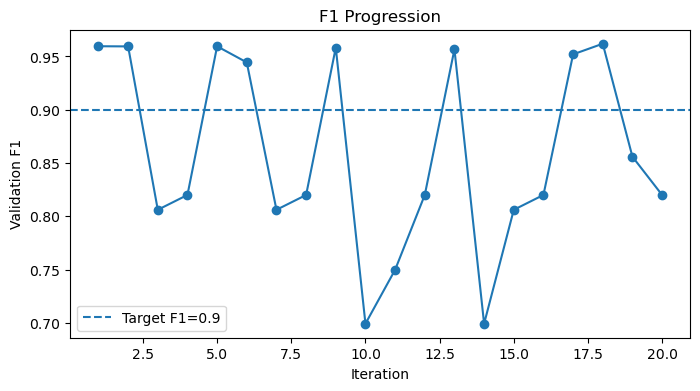

In [23]:
# %%
df_history = pd.DataFrame(training_history)

print("📈 Summary:")
print(f" • Total iterations: {len(df_history)}")
print(f" • Best val F1: {df_history['val_f1'].max():.4f}")
print(f" • Avg val F1: {df_history['val_f1'].mean():.4f}")
print(f" • # models >0.9: {(df_history['val_f1']>0.9).sum()}")

plt.figure(figsize=(8,4))
plt.plot(df_history['iteration'], df_history['val_f1'], marker='o')
plt.axhline(0.9, linestyle='--', label='Target F1=0.9')
plt.xlabel('Iteration')
plt.ylabel('Validation F1')
plt.title('F1 Progression')
plt.legend()
plt.show()


## 6. Save Training Results


In [24]:
import pickle
from datetime import datetime

os.makedirs('../models', exist_ok=True)

# Save best model
name, mdl = trainer.best_model
with open(f'../models/best_model_{name.lower().replace(" ","_")}.pkl','wb') as f:
    pickle.dump(mdl, f)

# Save feature extractor & tokenizer
with open('../models/feature_extractor.pkl','wb') as f:
    pickle.dump(feature_extractor, f)
with open('../models/tokenizer.pkl','wb') as f:
    pickle.dump(tokenizer, f)

# Save history
with open('../models/training_history.json','w',encoding='utf-8') as f:
    json.dump(training_history, f, ensure_ascii=False, indent=2)

# Build JSON-serializable summary
avg_f1      = float(df_history['val_f1'].mean())
std_f1      = float(df_history['val_f1'].std())
models_over = int((df_history['val_f1']>0.9).sum())
training_summary = {
    'total_iterations':      len(training_history),
    'best_model':            {'name': name, 'f1_score': float(trainer.best_f1_score)},
    'target_achieved':       bool(trainer.best_f1_score>0.9),
    'average_f1':            avg_f1,
    'std_f1':                std_f1,
    'models_over_target':    models_over,
    'training_completed_at': datetime.now().isoformat(),
    'dataset_size':          X_features.shape[0],
    'feature_count':         X_features.shape[1],
    'label_classes':         feature_extractor.label_encoder.classes_.tolist()
}
with open('../models/training_summary.json','w',encoding='utf-8') as f:
    json.dump(training_summary, f, ensure_ascii=False, indent=2)

print("✅ Artifacts saved under ../models")


✅ Artifacts saved under ../models
